## Oliwier Misztal   --------------   December 9, 2025
## Arthur Murphy
## Javi Jorge
# Molecular Modeling - Monte Carlo Methods

In [4]:
import numpy as np
from numba import njit
import time

# At first, we implement functions that are compiled with Numba for speed.

@njit
def create_nbr(L):
    """
    Creates the neighbor table for a 2D square lattice.
    Returns an array of shape (N, 4).
    """
    N = L * L
    nbr = np.zeros((N, 4), dtype=np.int64)
    
    # Pre-compute shifts (Periodic Boundaries)
    ip = np.arange(L) + 1
    im = np.arange(L) - 1
    ip[L - 1] = 0
    im[0] = L - 1
    
    for y in range(L):
        for x in range(L):
            i = x + y * L
            nbr[i, 0] = ip[x] + y * L   # Right neighbor
            nbr[i, 1] = im[x] + y * L   # Left neighbor
            nbr[i, 2] = x + ip[y] * L   # Up neighbor
            nbr[i, 3] = x + im[y] * L   # Down neighbor
            
    return nbr

@njit
def precompute_exponentials(T, nbr):
    """
    Analyzes the neighbor table to find 'z' (coordination number)
    and pre-computes the exponential table for all possible
    positive Delta E values.
    """
    beta = 1.0 / T
    
    # We analyze neighbors (nbr) to find 'z'
    # We assume a regular lattice where every site has the same number of neighbors.
    z = nbr.shape[1]  
    
    # We determine maximum possible energy change
    # Maximum change happens when flipping a spin surrounded by aligned neighbors.
    # Delta E = 2 * s_i * sum(neighbors). Max sum is z.
    # Max Delta E = 2 * 1 * z = 2z
    max_delta_E = 2 * z
    
    # We create the table
    # We need indices up to max_delta_E. 
    exp_table = np.zeros(max_delta_E + 1, dtype=np.float64)
    
    # We fill valid Delta E values
    # The sum of neighbors (h_i) goes from z down to -z in steps of 2.
    # We only care about POSITIVE Delta E (where we need the probability).
    # This corresponds to neighbor sums: z, z-2, z-4 ... > 0
    current_sum = z
    while current_sum > 0:
        delta_E = 2 * current_sum
        exp_table[delta_E] = np.exp(-beta * delta_E)
        current_sum -= 2
        
    return exp_table

@njit
def metropolis_step(state, nbr, exp_table):
    """
    Performs 1 Full Monte Carlo Step (N attempted flips).
    This is highly optimized machine code loop.
    """
    N = state.shape[0]
    z = nbr.shape[1] # Number of neighbors
    
    # Loop N times (1 MCS)
    for _ in range(N):
        # Pick random site
        i = np.random.randint(0, N)
        s_i = state[i]
        
        # Calculate sum of neighbors (Generic loop for any z)
        h_i = 0
        for k in range(z):
            h_i += state[nbr[i, k]]
        
        # Energy change
        delta_E = 2 * s_i * h_i
        
        # Metropolis Acceptance
        if delta_E <= 0:
            state[i] = -s_i # Accept & Flip
        else:
            # Look up probability
            if np.random.random() < exp_table[delta_E]:
                state[i] = -s_i # Accept & Flip
                
    return state

@njit
def measure_observables(state, nbr):
    """
    Calculates total Magnetization (M) and Energy (E) of the current state.
    """
    N = state.shape[0]
    z = nbr.shape[1]
    M = 0
    E = 0.0
    
    for i in range(N):
        M += state[i]
        
        # Calculate sum of neighbors for energy
        h_i = 0
        for k in range(z):
            h_i += state[nbr[i, k]]
            
        # E = - sum(s_i * s_j). 
        # We divide by 2.0 at the end to correct for double counting.
        E -= state[i] * h_i
        
    return E / 2.0, M

# Main Simulation Function

def run_simulation(L=100, T=2.27, mcs_steps=10000, n_meas=100, spins=None):
    # Setup
    N = L * L
    
    # Geometry
    nbr = create_nbr(L)
    
    # Smart Precalculation
    # This automatically detects if z=4 (square), z=6 (triangular), etc.
    exp_table = precompute_exponentials(T, nbr)

    # Pre-allocate arrays for measurements
    num_measurements = mcs_steps // n_meas
    energies = np.zeros(num_measurements, dtype=np.float64)
    magnetizations = np.zeros(num_measurements, dtype=np.int64)
    
    # Initialize Spins if not provided
    if spins is None:
        spins = np.random.choice(np.array([-1, 1], dtype=np.int8), size=N)
    
    # We need to JIT compile the functions before timing
    # So we run once with dummy data to force Numba to compile
    print("Compiling functions...")
    _ = metropolis_step(spins.copy(), nbr, exp_table)
    print("Compilation complete. Starting simulation...")
    
    # Start Timing
    start_time = time.time()
    
    # Run the optimized loop
    for step in range(mcs_steps):
        metropolis_step(spins, nbr, exp_table)
        # Measurement
        if step % n_meas == 0:
            idx = step // n_meas - 1
            E, M = measure_observables(spins, nbr)
            energies[idx] = E
            magnetizations[idx] = M
            if step % (n_meas * 100) == 0:
                print(f"Step {step}/{mcs_steps} completed.")
        
    end_time = time.time()
    elapsed = end_time - start_time
    
    # Statistics
    total_flips = N * mcs_steps
    flips_per_sec = total_flips / elapsed
    
    print(f"L={L}, T={T}, MCS={mcs_steps}")
    print(f"Time elapsed: {elapsed:.4f} s")
    print(f"Speed: {flips_per_sec:.2e} updates/second")
    
    return spins, energies, magnetizations

if __name__ == "__main__":
    run_simulation(L=100, T=2.27, mcs_steps=5000)

Compiling functions...
Compilation complete. Starting simulation...
Step 0/5000 completed.
L=100, T=2.27, MCS=5000
Time elapsed: 1.5451 s
Speed: 3.24e+07 updates/second


In [8]:
def read_configuration(filename):
    data = np.loadtxt(filename, dtype=int)
    spins = data[:, 1]
    return spins

In [9]:
def initialize_systems(L, initial_state='random', filename=None):
    N = L * L
    if initial_state == 'random':
        spins = np.random.choice(np.array([-1, 1], dtype=np.int8), size=N)
    elif initial_state == 'file' and filename is not None:
        spins = read_configuration(filename)
    else:
        raise ValueError("Invalid initial state or filename not provided.")
    return spins

In [10]:
L = 10
nbr = create_nbr(L)
N = L * L
spins_test_configuration = initialize_systems(L, initial_state='file', filename='test_configuration.dat')
spins_mys1 = initialize_systems(L, initial_state='file', filename='mys1.dat')
spins_mys2 = initialize_systems(L, initial_state='file', filename='mys2.dat')
spins_mys3 = initialize_systems(L, initial_state='file', filename='mys3.dat')
print(measure_observables(spins_test_configuration, nbr))
print(measure_observables(spins_mys1, nbr))
print(measure_observables(spins_mys2, nbr))
print(measure_observables(spins_mys3, nbr))

(-8.0, 8)
(8.0, -4)
(0.0, -4)
(-4.0, -6)


In [5]:
spins_last, energies, magnetizations = run_simulation(L=10, T=2.27, mcs_steps=5000, n_meas=100, spins=spins_test_configuration)

Compiling functions...
Compilation complete. Starting simulation...
L=10, T=2.27, MCS=5000
Time elapsed: 0.2312 s
Speed: 2.16e+06 updates/second


In [11]:
def read_energies(filename):
    data = np.loadtxt(filename)
    energies = data[:]
    return energies

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt

def binning_analysis(data, min_bins=100):
    """
    Optimized binning analysis using vectorized recursive averaging.
    
    Parameters:
        data: array-like, time series data
        min_bins: stop when number of bins is smaller than this (default 100)
    
    Returns:
        bin_sizes, bin_errors, bin_means
    """
    current_series = np.array(data)
    n_data = len(current_series)
    
    bin_sizes = []
    bin_errors = []
    bin_means = []
    
    m = 1
    
    # Continue until we have fewer than min_bins data points left
    while len(current_series) >= min_bins:
        # Calculate mean, standard deviation, and error for current level
        current_mean = np.mean(current_series)
        current_std = np.std(current_series, ddof=1)
        current_error = current_std / np.sqrt(len(current_series))
        
        # Store results
        bin_sizes.append(m)
        bin_means.append(current_mean)
        bin_errors.append(current_error)
        
        # Vectorized binning - using recursive averaging     
        # Truncate to even length to ensure perfect pairing
        limit = len(current_series) // 2 * 2
        # Fast numpy addition of even and odd indices
        current_series = (current_series[:limit:2] + current_series[1:limit:2]) / 2.0
        
        m *= 2
        
    return np.array(bin_sizes), np.array(bin_errors), np.array(bin_means)


def plotting_bins(bin_sizes, energy_means, energy_errors, file_name, AC_time):
    plt.errorbar(bin_sizes, energy_means, yerr=energy_errors, fmt='o-', capsize=5)
    plt.axvline(x=AC_time, color='r', linestyle='--', label='Autocorrelation Time')
    plt.xscale('log', base=10)
    plt.yscale('linear')
    plt.xlabel('Bin Size (m)')
    plt.ylabel('Mean Energy <E>')
    plt.title('Binning Analysis of Energy')
    plt.legend(['Autocorrelation Time', f'<E> with Error Bars from {file_name}'])
    plt.grid(True)
    plt.show()

for file in ['test1.dat', 'test2.dat', 'test3.dat']:

    # Run analysis
    energies = read_energies(file)
    start_time = time.time()
    bin_sizes, energy_errors, energy_means = binning_analysis(energies, min_bins=10)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Binning analysis completed in {elapsed:.6f} seconds.")
    print(f"\nEnergy binning (E):")
    print(f"{'m':<8} {'<E>':<15} {'Error':<15}")

    for m, em, err in zip(bin_sizes, energy_means, energy_errors):
        print(f"{m:<8} {em:<15.6f} {err:<15.6e}")

    if file == 'test1.dat':
        AC_time = 2 ** 8
    elif file == 'test2.dat':
        AC_time = 2 ** 14
    elif file == 'test3.dat':
        AC_time = 2 ** 13

    print(f"\nAutocorrelation time for {file}: {AC_time}")

    plotting_bins(bin_sizes, energy_means, energy_errors, file, AC_time)

NameError: name 'read_energies' is not defined

In [34]:
import numpy as np
import time
import matplotlib.pyplot as plt

def binning_analysis(data, min_bins=100):
    """
    Optimized binning analysis using vectorized recursive averaging.
    
    Parameters:
        data: array-like, time series data
        min_bins: stop when number of bins is smaller than this (default 100)
    
    Returns:
        bin_sizes, bin_errors, bin_means
    """
    current_series = np.array(data)
    n_data = len(current_series)
    
    bin_sizes = []
    bin_errors = []
    bin_means = []
    
    m = 1
    
    # Continue until we have fewer than min_bins data points left
    while len(current_series) >= min_bins:
        # Calculate mean, standard deviation, and error for current level
        current_mean = np.mean(current_series)
        current_std = np.std(current_series, ddof=1)
        current_error = current_std / np.sqrt(len(current_series))
        
        # Store results
        bin_sizes.append(m)
        bin_means.append(current_mean)
        bin_errors.append(current_error)
        
        # Vectorized binning - using recursive averaging     
        # Truncate to even length to ensure perfect pairing
        limit = len(current_series) // 2 * 2
        # Fast numpy addition of even and odd indices
        current_series = (current_series[:limit:2] + current_series[1:limit:2]) / 2.0
        
        m *= 2
        
    return np.array(bin_sizes), np.array(bin_errors), np.array(bin_means)


def plotting_bins(bin_sizes, energy_means, energy_errors, file_name, AC_time=None):
    plt.errorbar(bin_sizes, energy_means, yerr=energy_errors, fmt='o-', capsize=5)
    if AC_time is not None:
        plt.axvline(x=AC_time, color='r', linestyle='--', label='Autocorrelation Time')
    plt.xscale('log', base=10)
    plt.yscale('linear')
    plt.xlabel('Bin Size (m)')
    plt.ylabel('Mean Energy <E>')
    plt.title('Binning Analysis of Energy')
    plt.legend(['Autocorrelation Time', f'<E> with Error Bars from {file_name}'], loc='upper right', bbox_to_anchor=(1.2,1))
    plt.grid(True)
    plt.show()

In [5]:
spins, energies, magnetizations = run_simulation(L=4, T=5.0, mcs_steps=int(1e8))

Compiling functions...
Compilation complete. Starting simulation...
Step 0/100000000 completed.
Step 10000/100000000 completed.
Step 20000/100000000 completed.
Step 30000/100000000 completed.
Step 40000/100000000 completed.
Step 50000/100000000 completed.
Step 60000/100000000 completed.
Step 70000/100000000 completed.
Step 80000/100000000 completed.
Step 90000/100000000 completed.
Step 100000/100000000 completed.
Step 110000/100000000 completed.
Step 120000/100000000 completed.
Step 130000/100000000 completed.
Step 140000/100000000 completed.
Step 150000/100000000 completed.
Step 160000/100000000 completed.
Step 170000/100000000 completed.
Step 180000/100000000 completed.
Step 190000/100000000 completed.
Step 200000/100000000 completed.
Step 210000/100000000 completed.
Step 220000/100000000 completed.
Step 230000/100000000 completed.
Step 240000/100000000 completed.
Step 250000/100000000 completed.
Step 260000/100000000 completed.
Step 270000/100000000 completed.
Step 280000/100000000 

In [6]:
spins_2, energies_2, magnetizations_2 = run_simulation(L=4, T=2.0, mcs_steps=int(1e8))

Compiling functions...
Compilation complete. Starting simulation...
Step 0/100000000 completed.
Step 10000/100000000 completed.
Step 20000/100000000 completed.
Step 30000/100000000 completed.
Step 40000/100000000 completed.
Step 50000/100000000 completed.
Step 60000/100000000 completed.
Step 70000/100000000 completed.
Step 80000/100000000 completed.
Step 90000/100000000 completed.
Step 100000/100000000 completed.
Step 110000/100000000 completed.
Step 120000/100000000 completed.
Step 130000/100000000 completed.
Step 140000/100000000 completed.
Step 150000/100000000 completed.
Step 160000/100000000 completed.
Step 170000/100000000 completed.
Step 180000/100000000 completed.
Step 190000/100000000 completed.
Step 200000/100000000 completed.
Step 210000/100000000 completed.
Step 220000/100000000 completed.
Step 230000/100000000 completed.
Step 240000/100000000 completed.
Step 250000/100000000 completed.
Step 260000/100000000 completed.
Step 270000/100000000 completed.
Step 280000/100000000 

Binning analysis completed in 0.011103 seconds.

Energy binning (E):
m        <E>             Error           <E>/L^2            within exact range?
1        -28.076876      6.229363e-03    -1.754804750000000 yes
2        -28.076876      6.231265e-03    -1.754804750000000 yes
4        -28.076876      6.233401e-03    -1.754804750000000 yes
8        -28.076876      6.232533e-03    -1.754804750000000 yes
16       -28.076876      6.228132e-03    -1.754804750000000 yes
32       -28.076876      6.235710e-03    -1.754804750000000 yes
64       -28.076876      6.238293e-03    -1.754804750000000 yes
128      -28.076913      6.290562e-03    -1.754807057651690 yes
256      -28.076913      6.321018e-03    -1.754807057651690 yes
512      -28.076913      6.181099e-03    -1.754807057651690 yes
1024     -28.076808      6.209376e-03    -1.754800515096696 yes
2048     -28.076808      6.228557e-03    -1.754800515096696 yes
4096     -28.076808      5.765605e-03    -1.754800515096696 yes
8192     -28.076808

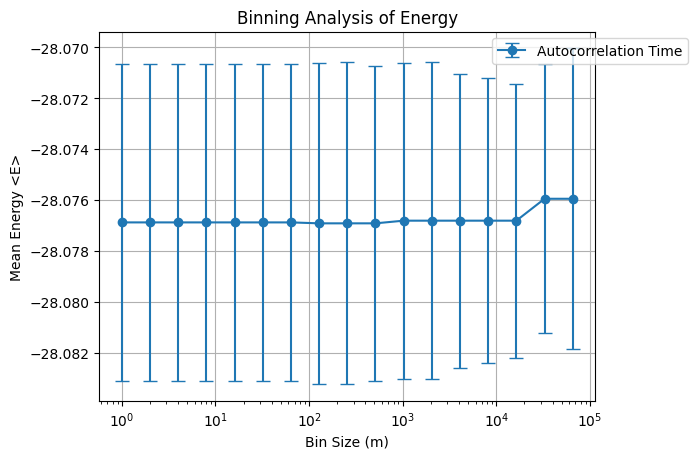

Binning analysis completed in 0.009007 seconds.

Energy binning (E):
m        <E>             Error           <E>/L^2            within exact range?
1        -7.314696       6.907828e-03    -0.457168500000000 yes
2        -7.314696       6.912774e-03    -0.457168500000000 yes
4        -7.314696       6.914848e-03    -0.457168500000000 yes
8        -7.314696       6.924543e-03    -0.457168500000000 yes
16       -7.314696       6.940463e-03    -0.457168500000000 yes
32       -7.314696       6.963385e-03    -0.457168500000000 yes
64       -7.314696       6.930928e-03    -0.457168500000000 yes
128      -7.314596       6.929747e-03    -0.457162258384537 yes
256      -7.314596       6.972231e-03    -0.457162258384537 yes
512      -7.314596       7.031649e-03    -0.457162258384537 yes
1024     -7.314261       7.025991e-03    -0.457141313396516 yes
2048     -7.314261       6.854885e-03    -0.457141313396516 yes
4096     -7.314261       7.072451e-03    -0.457141313396516 yes
8192     -7.314261 

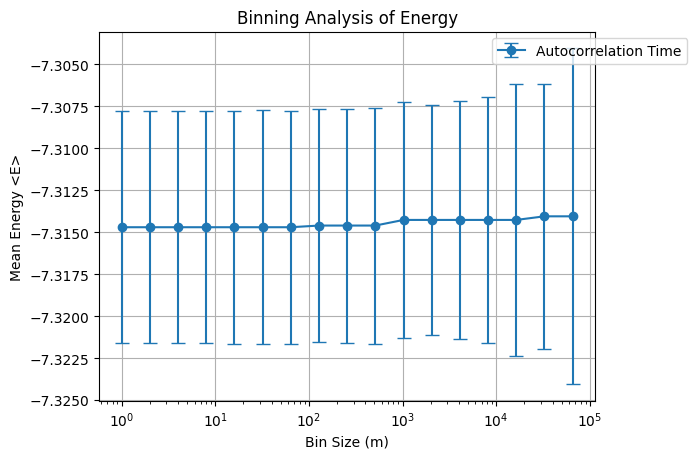

In [35]:
start_time = time.time()
bin_sizes, energy_errors, energy_means = binning_analysis(energies_2, min_bins=10)
end_time = time.time()
elapsed = end_time - start_time
print(f"Binning analysis completed in {elapsed:.6f} seconds.")
print(f"\nEnergy binning (E):")
print(f"{'m':<8} {'<E>':<15} {'Error':<15} {'<E>/L^2':<18} {'within exact range?':<15}")

for m, em, err in zip(bin_sizes, energy_means, energy_errors):
    print(f"{m:<8} {em:<15.6f} {err:<15.6e} {em/(4*4):<15.15f} {"yes" if em/(4*4) - err < -1.7553802888 < em/(4*4) + err else "NO"}")

plotting_bins(bin_sizes, energy_means, energy_errors, "L=4_T=2.0")

start_time = time.time()
bin_sizes, energy_errors, energy_means = binning_analysis(energies, min_bins=10)
end_time = time.time()
elapsed = end_time - start_time
print(f"Binning analysis completed in {elapsed:.6f} seconds.")
print(f"\nEnergy binning (E):")
print(f"{'m':<8} {'<E>':<15} {'Error':<15} {'<E>/L^2':<18} {'within exact range?':<15}")

for m, em, err in zip(bin_sizes, energy_means, energy_errors):
    print(f"{m:<8} {em:<15.6f} {err:<15.6e} {em/(4*4):<15.15f} {"yes" if em/(4*4) - err < -0.4561353695 < em/(4*4) + err else "NO"}")

plotting_bins(bin_sizes, energy_means, energy_errors, "L=4_T=5.0")


In [36]:
spins_20_2, energies_20_2, magnetizations_20_2 = run_simulation(L=20, T=2.0, mcs_steps=int(1e8))
spins_20_4, energies_20_4, magnetizations_20_4 = run_simulation(L=20, T=4.0, mcs_steps=int(1e8))

Compiling functions...
Compilation complete. Starting simulation...
Step 0/100000000 completed.
Step 10000/100000000 completed.
Step 20000/100000000 completed.
Step 30000/100000000 completed.
Step 40000/100000000 completed.
Step 50000/100000000 completed.
Step 60000/100000000 completed.
Step 70000/100000000 completed.
Step 80000/100000000 completed.
Step 90000/100000000 completed.
Step 100000/100000000 completed.
Step 110000/100000000 completed.
Step 120000/100000000 completed.
Step 130000/100000000 completed.
Step 140000/100000000 completed.
Step 150000/100000000 completed.
Step 160000/100000000 completed.
Step 170000/100000000 completed.
Step 180000/100000000 completed.
Step 190000/100000000 completed.
Step 200000/100000000 completed.
Step 210000/100000000 completed.
Step 220000/100000000 completed.
Step 230000/100000000 completed.
Step 240000/100000000 completed.
Step 250000/100000000 completed.
Step 260000/100000000 completed.
Step 270000/100000000 completed.
Step 280000/100000000 

Binning analysis completed in 0.017463 seconds.

Energy binning (E):
m        <E>             Error           <E>/L^2            within exact range?
1        -698.183300     3.404796e-02    -1.745458250000000 yes
2        -698.183300     3.404292e-02    -1.745458250000000 yes
4        -698.183300     3.402346e-02    -1.745458250000000 yes
8        -698.183300     3.396052e-02    -1.745458250000000 yes
16       -698.183300     3.389923e-02    -1.745458250000000 yes
32       -698.183300     3.396886e-02    -1.745458250000000 yes
64       -698.183300     3.400550e-02    -1.745458250000000 yes
128      -698.184164     3.419842e-02    -1.745460409466206 yes
256      -698.184164     3.429355e-02    -1.745460409466206 yes
512      -698.184164     3.452566e-02    -1.745460409466206 yes
1024     -698.183814     3.442461e-02    -1.745459534691983 yes
2048     -698.183814     3.469266e-02    -1.745459534691983 yes
4096     -698.183814     3.443313e-02    -1.745459534691983 yes
8192     -698.18381

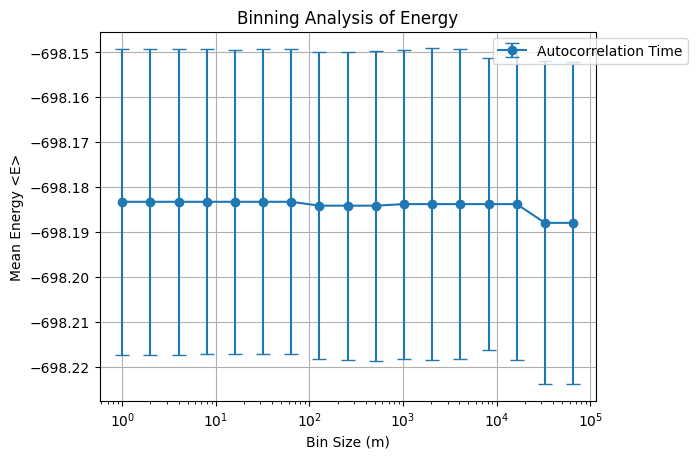

Binning analysis completed in 0.012494 seconds.

Energy binning (E):
m        <E>             Error           <E>/L^2           
1        -222.789304     3.306200e-02    -0.556973260000000
2        -222.789304     3.310016e-02    -0.556973260000000
4        -222.789304     3.313894e-02    -0.556973260000000
8        -222.789304     3.312478e-02    -0.556973260000000
16       -222.789304     3.314000e-02    -0.556973260000000
32       -222.789304     3.321520e-02    -0.556973260000000
64       -222.789304     3.344495e-02    -0.556973260000000
128      -222.789071     3.380513e-02    -0.556972676251280
256      -222.789071     3.387590e-02    -0.556972676251280
512      -222.789071     3.373893e-02    -0.556972676251280
1024     -222.788618     3.426568e-02    -0.556971545610272
2048     -222.788618     3.455623e-02    -0.556971545610272
4096     -222.788618     3.404576e-02    -0.556971545610272
8192     -222.788618     3.509554e-02    -0.556971545610272
16384    -222.788618     3.9110

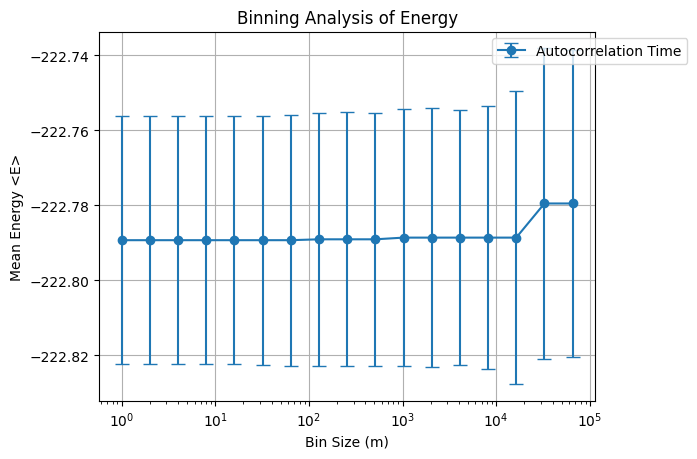

In [37]:
start_time = time.time()
bin_sizes, energy_errors, energy_means = binning_analysis(energies_20_2, min_bins=10)
end_time = time.time()
elapsed = end_time - start_time
print(f"Binning analysis completed in {elapsed:.6f} seconds.")
print(f"\nEnergy binning (E):")
print(f"{'m':<8} {'<E>':<15} {'Error':<15} {'<E>/L^2':<18} {'within exact range?':<15}")

for m, em, err in zip(bin_sizes, energy_means, energy_errors):
    print(f"{m:<8} {em:<15.6f} {err:<15.6e} {em/(20*20):<15.15f} {"yes" if em/(20*20) - err < -1.7455571250 < em/(20*20) + err else "NO"}")

plotting_bins(bin_sizes, energy_means, energy_errors, "L=20_T=2.0")

start_time = time.time()
bin_sizes, energy_errors, energy_means = binning_analysis(energies_20_4, min_bins=10)
end_time = time.time()
elapsed = end_time - start_time
print(f"Binning analysis completed in {elapsed:.6f} seconds.")
print(f"\nEnergy binning (E):")
print(f"{'m':<8} {'<E>':<15} {'Error':<15} {'<E>/L^2':<18}")

for m, em, err in zip(bin_sizes, energy_means, energy_errors):
    print(f"{m:<8} {em:<15.6f} {err:<15.6e} {em/(20*20):<15.15f}")

plotting_bins(bin_sizes, energy_means, energy_errors, "L=20_T=4.0")

Compiling functions...
Compilation complete. Starting simulation...
Step 0/100000000 completed.
Step 1000/100000000 completed.
Step 2000/100000000 completed.
Step 3000/100000000 completed.
Step 4000/100000000 completed.
Step 5000/100000000 completed.
Step 6000/100000000 completed.
Step 7000/100000000 completed.
Step 8000/100000000 completed.
Step 9000/100000000 completed.
Step 10000/100000000 completed.
Step 11000/100000000 completed.
Step 12000/100000000 completed.
Step 13000/100000000 completed.
Step 14000/100000000 completed.
Step 15000/100000000 completed.
Step 16000/100000000 completed.
Step 17000/100000000 completed.
Step 18000/100000000 completed.
Step 19000/100000000 completed.
Step 20000/100000000 completed.
Step 21000/100000000 completed.
Step 22000/100000000 completed.
Step 23000/100000000 completed.
Step 24000/100000000 completed.
Step 25000/100000000 completed.
Step 26000/100000000 completed.
Step 27000/100000000 completed.
Step 28000/100000000 completed.
Step 29000/100000

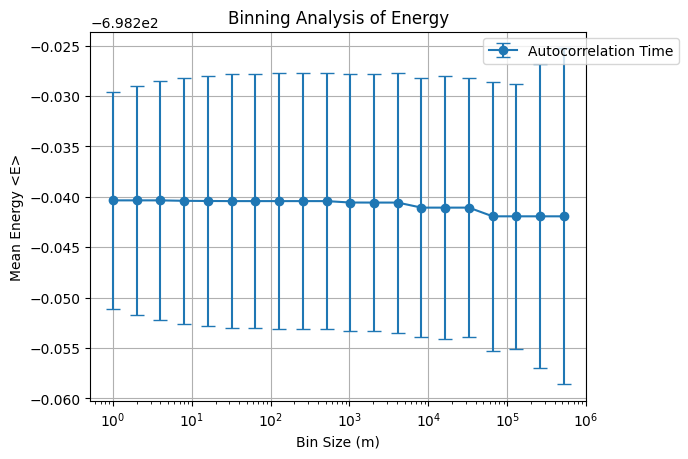

In [38]:
spins_20_2_ev10, energies_20_2_ev10, magnetizations_20_2_ev10 = run_simulation(L=20, T=2.0, mcs_steps=int(1e8), n_meas=10)

start_time = time.time()
bin_sizes, energy_errors, energy_means = binning_analysis(energies_20_2_ev10[100:], min_bins=10)    # Exclude first 1000 measurements (100 * 10)
end_time = time.time()
elapsed = end_time - start_time
print(f"Binning analysis completed in {elapsed:.6f} seconds.")
print(f"\nEnergy binning (E):")
print(f"{'m':<8} {'<E>':<15} {'Error':<15} {'<E>/L^2':<18} {'within exact range?':<15}")

for m, em, err in zip(bin_sizes, energy_means, energy_errors):
    print(f"{m:<8} {em:<15.6f} {err:<15.6e} {em/(20*20):<15.15f} {"yes" if em/(20*20) - err < -1.7455571250 < em/(20*20) + err else "NO"}")

plotting_bins(bin_sizes, energy_means, energy_errors, "L=20_T=2.0 without initial 1000 measurements")

In [ ]:
T = [2.0, 2.27, 2.6]
mcs_steps = int(1e6)
Energies_dict = {}
Magnetizations_dict = {}
for temp in T:
    spins_temp, energies_temp, magnetizations_temp = run_simulation(L=100, T=temp, mcs_steps=mcs_steps, n_meas=10)
    Energies_dict[temp] = energies_temp
    Magnetizations_dict[temp] = magnetizations_temp

In [ ]:
def plot_energies_short(Energies_dict):
    plt.figure(figsize=(10, 6))
    for T, energies in Energies_dict.items():
        plt.plot(energies[:100], label=f'T={T}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Energy')
    plt.title('Energy Time Series for Different Temperatures (L=100)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_energies_long(Energies_dict):
    plt.figure(figsize=(10, 6))
    for T, energies in Energies_dict.items():
        plt.plot(energies, label=f'T={T}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Energy')
    plt.title('Energy Time Series for Different Temperatures (L=100)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_magnetizations_short(Magnetizations_dict):
    plt.figure(figsize=(10, 6))
    for T, magnetizations in Magnetizations_dict.items():
        plt.plot(magnetizations[:100], label=f'T={T}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Magnetization')
    plt.title('Magnetization Time Series for Different Temperatures (L=100)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_magnetizations_long(Magnetizations_dict):
    plt.figure(figsize=(10, 6))
    for T, magnetizations in Magnetizations_dict.items():
        plt.plot(magnetizations, label=f'T={T}')
    plt.xlabel('Measurement Index')
    plt.ylabel('Magnetization')
    plt.title('Magnetization Time Series for Different Temperatures (L=100)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_energies_short(Energies_dict)
plot_energies_long(Energies_dict)
plot_magnetizations_short(Magnetizations_dict)
plot_magnetizations_long(Magnetizations_dict)
